# Exploritory data analysis

Firstly let's download the processed jsons and dicts with info about countries and occupations:

In [43]:
import json
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import networkx
import networkx as nt
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
from networkx.algorithms.components.connected import connected_components

from preprocessing import *

In [44]:
WIKI_FIELDS = ['gender', 'occupation_ids', 'citizenship_id']

In [45]:
data = []

with open('union.json') as file:
    data = json.load(file)
        
with open('mapping.json') as file:
    mapping = json.load(file)

In [46]:
countries_dict = mapping['countries']
occupations_dict = mapping['occupations']

## Cleaning the data

Sometimes in wikidata there are people with the same names. In such cases length of features (e.g. gender) in dataset is greater than one.

Secondly, for some uids (qids), wikipedia pages may be missing. In this case number of elements in features arrays (e.g. gender) may be less than length of uids.

Thus, the pipeline would be:
 1. Delete objects from data which don't contain elements in feature arrays (e.g. gender = [])
 2. Process data items with several elements in feature arrays (to extract only one set of features)

In [47]:
data_single_item = []
data_multiple_items = []
for item in data:
    if len(item['gender']) > 1:
        data_multiple_items.append(item)
    elif len(item['gender']) == 1:
        if all(item[field][0] is not None for field in WIKI_FIELDS): # if all features are filled
            item = select_by_index(item, 0)
            data_single_item.append(item)
    # else drop elements that have empty feature arrays

In [48]:
len(data_multiple_items), len(data_single_item)

(20221, 49220)

Now let us obtain the distribution of speakers which names match to several wiki pages

In [49]:
name2occur = defaultdict(int)
for item in data_multiple_items:
    name2occur[item['speaker'].lower()] += 1
    
sorted(name2occur.items(), key=lambda x: x[1], reverse=True)[:10]

[('john kerry', 456),
 ('jerry brown', 363),
 ('michael mann', 341),
 ('gordon brown', 253),
 ('donald trump', 211),
 ('manmohan singh', 198),
 ('james hansen', 147),
 ('stephen harper', 143),
 ('tony abbott', 133),
 ('nicholas stern', 132)]

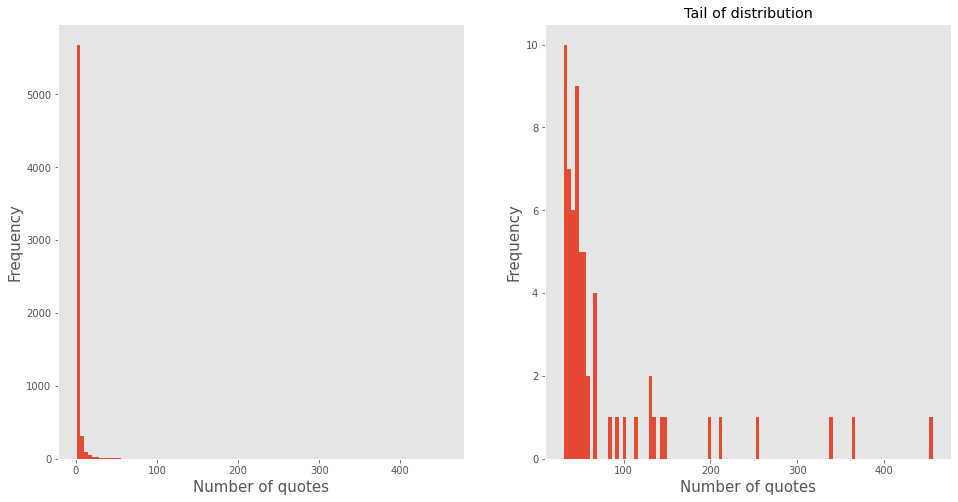

In [50]:
vals = np.array(list(name2occur.values()))

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.hist(vals, bins=100)
plt.xlabel('Number of quotes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.grid()

plt.subplot(122)
plt.hist(vals[vals > 30], bins=100)
plt.xlabel('Number of quotes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Tail of distribution')
plt.grid()

plt.show()

Let us now filter the feature arrays by deleting ones filled with Nones

In [51]:
data_multiple_items_new = []

for item in data_multiple_items:
    not_none_ids = []
    for index in range(len(item[WIKI_FIELDS[0]])):
        if all(item[field][index] is not None for field in WIKI_FIELDS):
            not_none_ids.append(index)
    
    if len(not_none_ids) == 1:
        item = select_by_index(item, not_none_ids[0])
        data_single_item.append(item)
    else:
        data_multiple_items_new.append(item)

data_multiple_items = data_multiple_items_new

In [52]:
len(data_multiple_items), len(data_single_item)

(16452, 52989)

Finally, if there are several wikipages left, let us keep the person with the most number of occupations. The underlying hypothesis is that such person is more likely to be quotated.

In [53]:
for item in data_multiple_items:
    occ_lengths = [len(occ) if occ is not None else 0 for occ in item['occupation_ids']]
    idx = np.argmax(occ_lengths)
    
    item = select_by_index(item, idx)
    data_single_item.append(item)

In [54]:
data = data_single_item

## Occupations

We want to explore the "popularity" of the trend among specific occupation. We propose to count the number of quatation with tag "climate change" per occupation. This is how we can estimate how famous is this topic among occupation.

However, there a lot of similar occupations, which have slightly different names. For example, 'art director' and 'director'. We propose to make clusters with simalar occupations. We decided to manage this problem in the folowing way:
1. Calculate the Levenshtein distance between each pair of occupation names. Make a matrix which satisfies folowing criterions: 

$$dist[i,j] = \begin{cases} 1, & \text{ if } Lewdist(i,j) > threshold \\ 0, & \text{ else } \end{cases}$$

2. Make a graph with adjacency matrix = dist.
3. Find in this graph all cliques.
4. Cliques of size > 2 are our clusters.


Each cluster consists of at least 1 occupation. So we decided to choose the shortest name of occupation for the cluster. 

For example: occupations: **[myrmecologist, gynaecologist, ecologist, marine ecologist]** -> cluster name: **ecologist**.

In [55]:
occupations = []
nones = []
for quat in data:
    if quat['occupation_ids']:
        occupations.extend(quat['occupation_ids'])
    else:
        nones.append(quat['speaker'])

In [56]:
occupations_dist = [occupations_dict[i] for i in occupations]
c = Counter(occupations_dist)   
c = sorted(dict(c).items(), key = lambda x: x[1]) 

In [57]:
occupations_dist[:10]

['politician',
 'physicist',
 'head of state',
 'politician',
 'university teacher',
 'political scientist',
 'politician',
 'motivational speaker',
 'autobiographer',
 'painter']

#### Now let's figure out the most common occupations:

In [58]:
c[::-1][:15]

[('politician', 35703),
 ('lawyer', 11260),
 ('writer', 8023),
 ('journalist', 5787),
 ('diplomat', 5645),
 ('university teacher', 5368),
 ('economist', 3947),
 ('actor', 3588),
 ('businessperson', 3299),
 ('statesperson', 3241),
 ('jurist', 3215),
 ('environmentalist', 3101),
 ('community organizer', 2952),
 ('political writer', 2858),
 ('entrepreneur', 2293)]

Occupations are simalar sometimes. For example: **artist** and **sound artist**, so we make some clusters for occupations. 

In [59]:
occ_set = [i[0] for i in c]
cliq_finder = CliqueFinder(occ_set)
cliques = cliq_finder.find_clique_final()

### Let's draw the graph for occupation, to visualised the existence of edge between different occupations

In [60]:
labeldict = dict(zip(np.arange(len(cliq_finder.occ_set)), occ_set))

cliques_nodes = []
for i in cliques:
    if len(i) > 3:
        cliques_nodes.extend(i)
cliques_nodes = list(set(cliques_nodes))
cliques_nodes_names = [labeldict[i] for i in cliques_nodes]

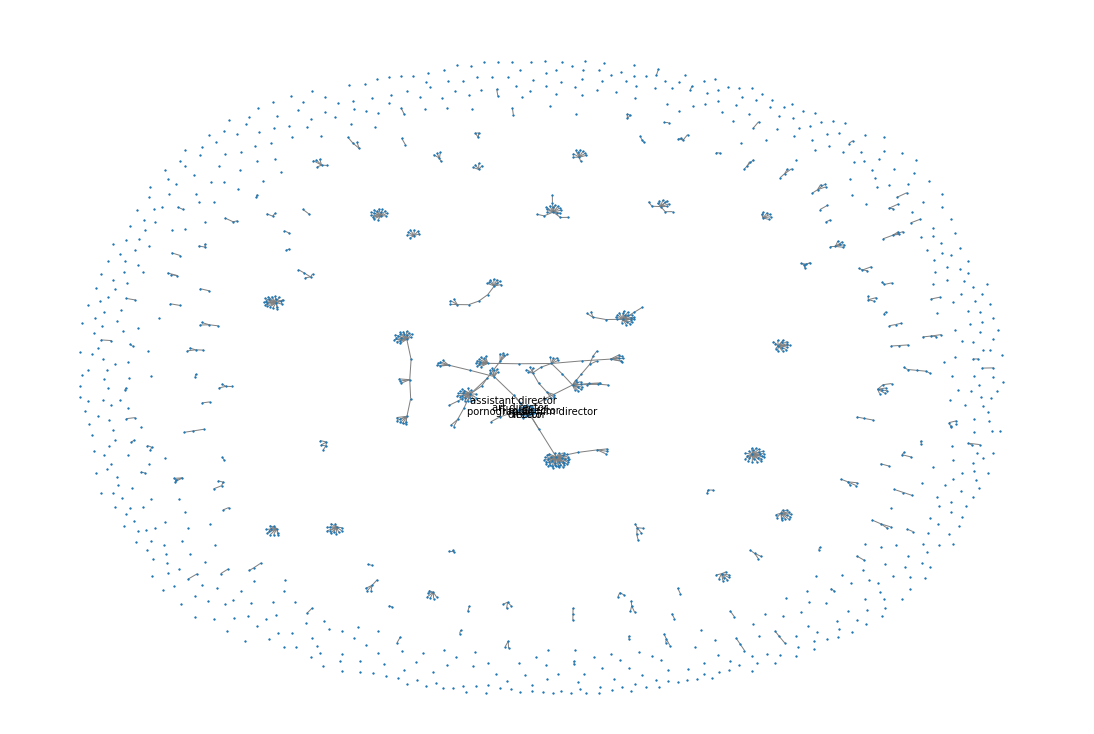

In [61]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
labels = labeldict
networkx.draw(cliq_finder.G, node_size=3,labels = dict(zip(cliques_nodes, cliques_nodes_names)),
              font_size=10, edge_color = 'grey', font_color='black', 
              verticalalignment='top', style="solid")

### Creating clusters for occupations:

In [62]:
cliques_graph = Graph(cliques)

occ_similar = list(connected_components(cliques_graph.make_graph()))
clusters_occ_dict = {i: list(map(lambda x: labeldict[x], c)) for i,c in enumerate(occ_similar)}
clusters_occ_dict_one = {}

for i, cluster in enumerate(occ_similar):
    occupation_list = sorted(list(map(lambda x: labeldict[x], cluster)), key = lambda x: len(x))
    clusters_occ_dict_one[i] = occupation_list[0]
    
# clusters_counter = [get_cluster_name(i) for i in occ_set]

In [72]:
#example:
clusters_occ_dict[13], clusters_occ_dict_one[13]

(['human rights activist',
  'political activist',
  'social activist',
  'HIV activist',
  'anti-vaccine activist',
  'anti-nuclear activist',
  'voting rights activist',
  'pro-life activist',
  "children's rights activist",
  'Internet activist',
  "women's rights activist",
  'climate activist',
  'peace activist',
  'LGBTQIA+ rights activist',
  'activist'],
 'activist')

In [73]:
clusters_counter = [define_cluster(i, clusters_occ_dict) for i in occ_set]

In [74]:
occupations_count_clusters = {clusters_occ_dict_one[i]: num for i, num in Counter(clusters_counter).items()}
data_occ = pd.DataFrame(occupations_count_clusters.values(), index=occupations_count_clusters.keys(), 
             columns = ['frequency'])

In [75]:
data_occ.sort_values(by = ['frequency'], inplace = True)
data_occ = data_occ.iloc[::-1]

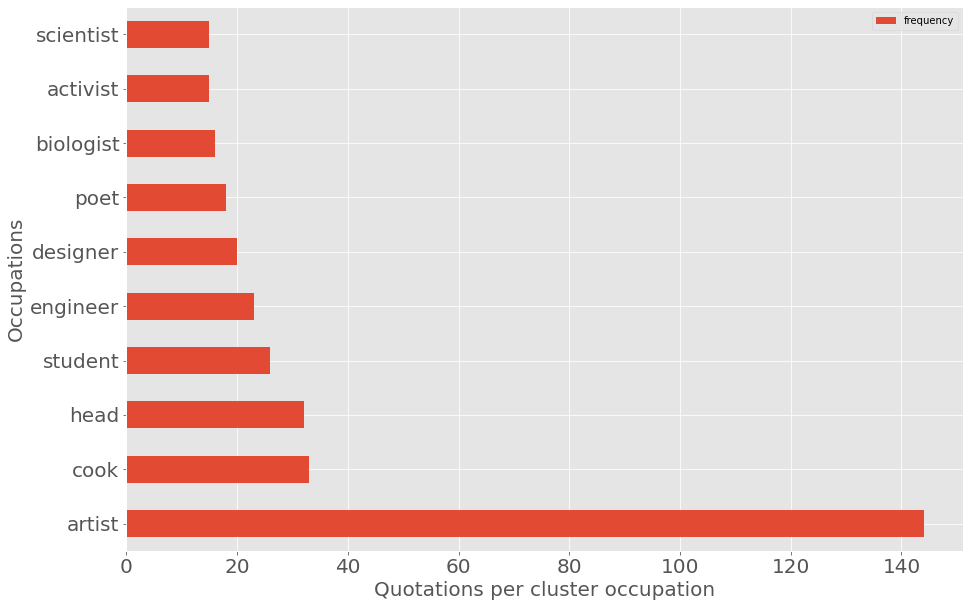

In [76]:
ax = data_occ.iloc[:10].plot.barh(figsize=(15,10), fontsize=20)
ax.set_xlabel('Quotations per cluster occupation', fontsize=20)
ax.set_ylabel('Occupations', fontsize=20)
plt.show()

# Countries

We also want to explore the "popularity" of the trend in terms of countries.

In [78]:
country2occur = defaultdict(int)
for item in data:
    country_id = item['citizenship_id']
    if country_id is not None:
        country2occur[countries_dict[country_id]] += 1

In [79]:
countries_frec = pd.DataFrame(dict(country2occur).items(), columns=['country', 'frequency'])
countries_frec = countries_frec.set_index('country')
countries_frec.sort_values(by=['frequency'], ascending=False, inplace=True)

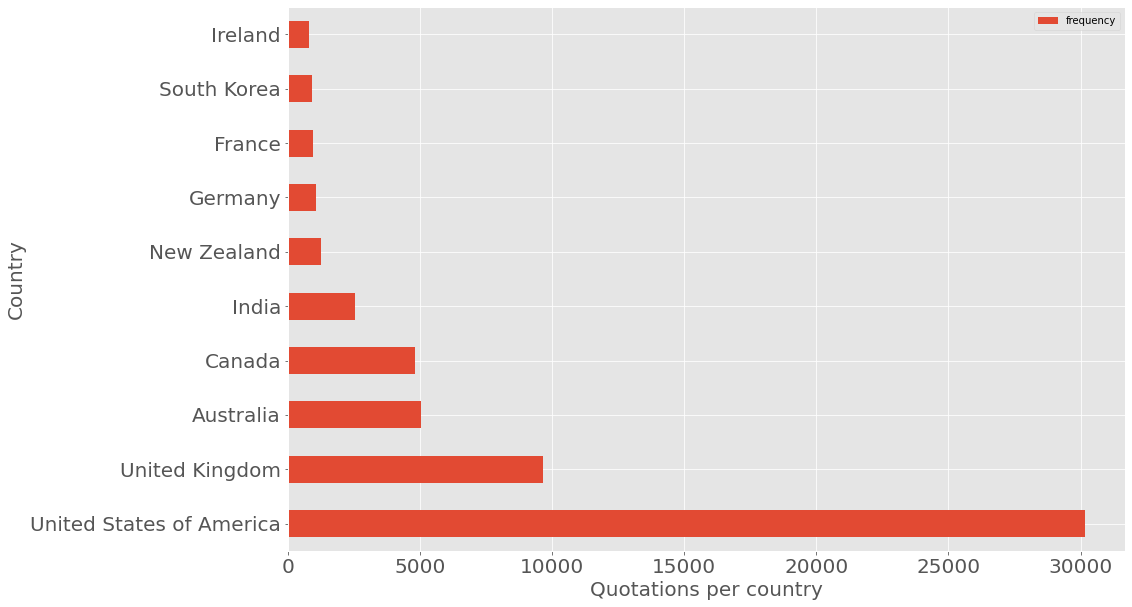

In [80]:
ax = countries_frec.iloc[:10].plot.barh(figsize=(15,10), fontsize=20)
ax.set_xlabel('Quotations per country', fontsize=20)
ax.set_ylabel('Country', fontsize=20)
plt.show()

# Timeline distribution

Let's check the distribution of qoutes across the year for different years

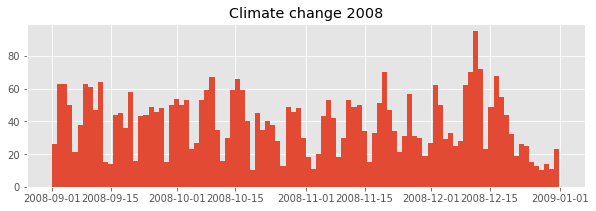

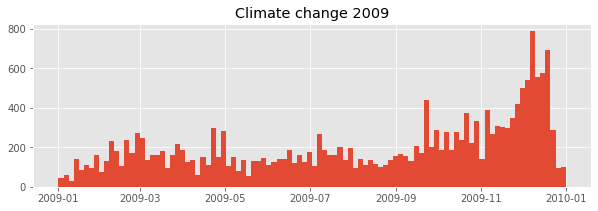

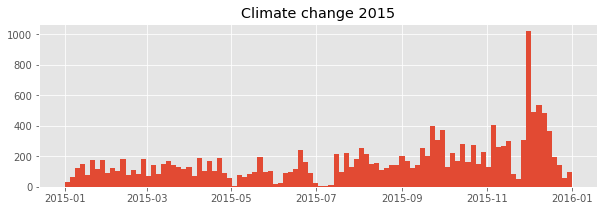

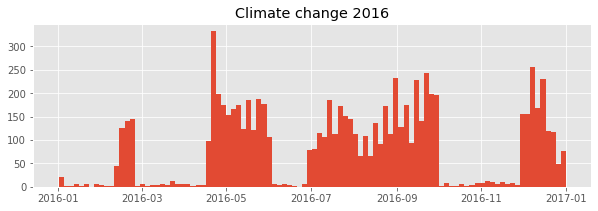

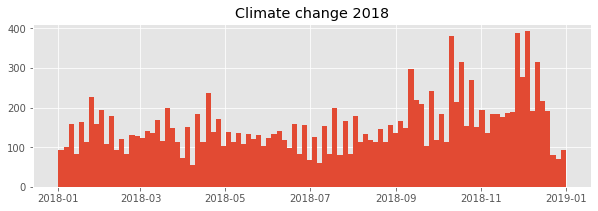

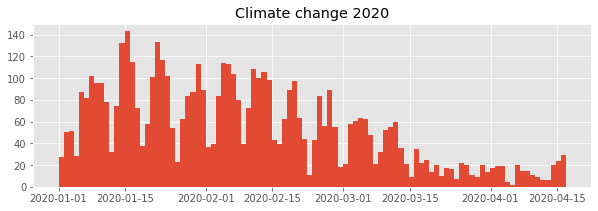

<Figure size 720x216 with 0 Axes>

In [84]:
data_listed = []
for quote_json in data:
    qoute = quote_json['quotation']
    date = quote_json['date']
    gender = quote_json['speaker']
    data_listed.append([qoute, date, gender])

data_df = pd.DataFrame(data_listed, columns=['qoute','date','gender'])
data_df['date'] = pd.to_datetime(data_df['date'])

plt.figure(figsize=(10,3))
for year in sorted(list(set(data_df['date'].dt.year))):
    subdf = data_df[data_df['date'].dt.year==year]
    subdf['date'].hist(bins=100)
    plt.title('Climate change' + " " + str(year))
    plt.figure(figsize=(10,3))

We can clearly see that the distribution across different years is completely different. We are going to check the distribuiton of other trends in the next steps of analysis. It could be an interesting insights about the data, but we should be precise because it could be a dataset bias or real world changes.